## Read me

 구글폼에서 이미 분석 결과를 제공해주지만, <br>
 설문조사에 공유우산을 사용할/ 하지 않은 이유를 직접 쓰는 란이 있었다.
<br>직접 써주신 의견을 모아서 어떤 부분이 가장 중요했을지를 살핀다.
<br>설명가능한 AI - shap 점수, linear model의 feature importance 등을 활용.

한글 폰트 때문에 이거 먼저 돌리고 런타임 다시시작 후 그 밑부터 돌린다.

In [ ]:
# 얘를 먼저 돌리고, 위 매뉴에서 runtime 다시시작해야 한글이 안깨지고 transfomer model fine tune 가능
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install transformers
!pip install accelerate -U

여기부터 런타임 다시시작 후

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
prop = fm.FontProperties(fname=path)

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False


## data

In [ ]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('DAB 설문조사.csv')
print(len(df))
df.columns

178


Index(['타임스탬프', '다음 중 어느 연령대에 속하십니까?', '성별이 어떻게 되십니까?', '현재 직업은 무엇입니까?',
       '평소 양산을 사용하십니까? ', '양산을 사용하지 않는 이유가 무엇입니까? (복수응답 가능)',
       '양산을 사용하게 된다면 어느 계절에 사용하게 될 것 같습니까? (복수응답 가능)',
       '양산을 사용하게 된다면 언제 사용하게 될 것 같습니까? (복수응답 가능)',
       '공유양산 대여 시스템을 이용할 의향이 있으십니까?', '사용을 원하는/원치 않는 이유가 무엇입니까?',
       '양산을 어느 계절에 이용하십니까? (복수응답 가능)', '이전 질문에 답하신 계절에 양산을 얼마나 자주 이용하십니까?',
       '양산을 주로 언제 이용하십니까? (복수응답 가능)', '공유양산 대여 시스템을 이용할 의향이 있으십니까?.1',
       '사용을 원하는/원치 않는 이유가 무엇입니까?.1', '우산이 없는데 비가 오는 경우에 우산을 구매하십니까?',
       '다음 중 우산을 구입하기 망설여지는 이유에 해당하는 것이 있습니까? (복수응답 가능)',
       '공유우산 대여 시스템을 이용할 의향이 있으십니까?', '사용을 원하는/원치 않는 이유가 무엇입니까?.2',
       '우양산 대여 시스템을 이용하게 된다면 어느 장소에서 대여하는 것을 선호하십니까? (복수응답 가능)',
       '우양산 대여 시스템을 이용하게 된다면 어느 장소에서 반납하는 것을 선호하십니까? (복수응답 가능)',
       '공유 우양산 대여 시스템 이용 시 정기권과 일일권 중 어느 것을 선호하십니까?',
       '공유 우양산 대여 시스템 이용 시 웹과 어플 중 어떤 방식을 선호하십니까?'],
      dtype='object')

## 자연어 처리

사용을 원하는 이유와 원치 않는 이유를 알아보기 위해 자연어 처리

In [ ]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 13.5 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

In [ ]:
# Initialize Korean tokenizer
okt = Okt()

# 예, 아니오 labeling
# 공유우산을 사용할 의향이 있으십니까?
# 예 -> label = 1   #아니오 -> label = 0
df_um = pd.DataFrame()
df_par = pd.DataFrame()
df_par_no = pd.DataFrame()
df_all = pd.DataFrame()

# 평소 양산 사용하지 않는 사람
df_par_no['label'] = df['공유양산 대여 시스템을 이용할 의향이 있으십니까?'].apply(lambda x: 1 if x == '예' else 0 if x == '아니오' else np.nan)
df_par_no['text'] =  df['사용을 원하는/원치 않는 이유가 무엇입니까?']
df_par_no = df_par_no.dropna()

# 평소 양산 사용자
df_par['label'] = df['공유양산 대여 시스템을 이용할 의향이 있으십니까?.1'].apply(lambda x: 1 if x == '예' else 0 if x == '아니오' else np.nan)
df_par['text'] =  df['사용을 원하는/원치 않는 이유가 무엇입니까?.1']
df_par = df_par.dropna()

# 우산 - 평소 모두 사용한다는 가정
df_um['label'] = df['공유우산 대여 시스템을 이용할 의향이 있으십니까?'].apply(lambda x: 1 if x == '예' else 0 if x == '아니오' else np.nan)
df_um['text'] = df['사용을 원하는/원치 않는 이유가 무엇입니까?.2']
df_um = df_um.dropna()


# Tokenize and remove stop words
df_par['Tokenized_Text'] = df_par['text'].apply(okt.morphs)
df_par_no['Tokenized_Text'] = df_par_no['text'].apply(okt.morphs)
df_um['Tokenized_Text'] = df_um['text'].apply(okt.morphs)
df_all = pd.concat([df_par, df_par_no, df_um])

#불용어 제거
# 더 제거해볼 것 : 굳이 잘 못 등 같은 경우 트리 모델에서 '굳이'가 있을 때 -> '반납' 도 있다면 -> 0 처럼 영향을 미칠 수 있다.
stop_ = "하는, 하는게, 그냥, 있으면, 같아서, 굳이, 못, 안, 잘, 움, 때문, 대, 적, 너무, 수, ,, ., .., 우산, 양산, c, ㄹ, ㅎ, 할, 같아서, 같음, 같아요, 없음, 같습니다, 이나, 느껴서, 않습니다, 이용, 경우, 생각, 함, 도, 공유, 같은, 하면, 하지, 특히, 사용, 보다, 보다는, 기, 라면, 이기, 에는, 하고, 하기, 인해, 아, 휴, 어, 나, 우리, 도, 만, 은, 는, 저희, 따라, 의해, 을, 를, 에, 의, 가, 으로, 로, 에게, 뿐이다, 의거하여, 근거하여, 입각하여, 기준으로, 예하면, 예를 들면, 예를 들자면, 저, 소인, 소생, 저희, 지말고, 하지마, 하지마라, 다른, 물론, 또한, 그리고, 비길수 없다, ?, !, 해서는 안된다, 뿐만 아니라, 만이 아니다, 만은 아니다, 막론하고, 관계없이, 그치지 않다, 그러나, 그런데, 하지만, 든간에, 논하지 않다, 따지지 않다, 설사, 비록, 더라도, 아니면, 만 못하다, 하는 편이 낫다, 불문하고, 향하여, 향해서, 향하다, 쪽으로, 틈타, 이용하여, 타다, 오르다, 제외하고, 이 외에, 이 밖에, 하여야, 비로소, 한다면 몰라도, 외에도, 이곳, 여기, 부터, 기점으로, 따라서, 할 생각이다, 하려고하다, 이리하여, 그리하여, 그렇게 함으로써, 하지만, 일때, 할때, 앞에서, 중에서, 보는데서, 으로써, 로써, 까지, 해야한다, 일것이다, 반드시, 할줄알다, 할수있다, 할수있어, 임에 틀림없다, 한다면, 등, 등등, 제, 겨우, 단지, 다만, 할뿐, 딩동, 댕그, 대해서, 대하여, 대하면, 훨씬, 얼마나, 얼마만큼, 얼마큼, 남짓, 여, 얼마간, 약간, 다소, 좀, 조금, 다수, 몇, 얼마, 지만, 하물며, 또한, 그러나, 그렇지만, 하지만, 이외에도, 대해 말하자면, 뿐이다, 다음에, 반대로, 반대로 말하자면, 이와 반대로, 바꾸어서 말하면, 바꾸어서 한다면, 만약, 그렇지않으면, 까악, 툭, 딱, 삐걱거리다, 보드득, 비걱거리다, 꽈당, 응당, 해야한다, 에 가서, 각, 각각, 여러분, 각종, 각자, 제각기, 하도록하다, 와, 과, 그러므로, 그래서, 고로, 한 까닭에, 하기 때문에, 거니와, 이지만, 대하여, 관하여, 관한, 과연, 실로, 아니나다를가, 생각한대로, 진짜로, 한적이있다, 하곤하였다, 하, 하하, 허허, 아하, 거바, 와, 오, 왜, 어째서, 무엇때문에, 어찌, 하겠는가, 무슨, 어디, 어느곳, 더군다나, 하물며, 더욱이는, 어느때, 언제, 야, 이봐, 어이, 여보시오, 흐흐, 흥, 휴, 헉헉, 헐떡헐떡, 영차, 여차, 어기여차, 끙끙, 아야, 앗, 아야, 콸콸, 졸졸, 좍좍, 뚝뚝, 주룩주룩, 솨, 우르르, 그래도, 또, 그리고, 바꾸어말하면, 바꾸어말하자면, 혹은, 혹시, 답다, 및, 그에 따르는, 때가 되어, 즉, 지든지, 설령, 가령, 하더라도, 할지라도, 일지라도, 지든지, 몇, 거의, 하마터면, 인젠, 이젠, 된바에야, 된이상, 만큼	어찌됏든, 그위에, 게다가, 점에서 보아, 비추어 보아, 고려하면, 하게될것이다, 일것이다, 비교적, 좀, 보다더, 비하면, 시키다, 하게하다, 할만하다, 의해서, 연이서, 이어서, 잇따라, 뒤따라, 뒤이어, 결국, 의지하여, 기대여, 통하여, 자마자, 더욱더, 불구하고, 얼마든지, 마음대로, 주저하지 않고, 곧, 즉시, 바로, 당장, 하자마자, 밖에 안된다, 하면된다, 그래, 그렇지, 요컨대, 다시 말하자면, 바꿔 말하면, 즉, 구체적으로, 말하자면, 시작하여, 시초에, 이상, 허, 헉, 허걱, 바와같이, 해도좋다, 해도된다, 게다가, 더구나, 하물며, 와르르, 팍, 퍽, 펄렁, 동안, 이래, 하고있었다, 이었다, 에서, 로부터, 까지, 예하면, 했어요, 해요, 함께, 같이, 더불어, 마저, 마저도, 양자, 모두, 습니다, 가까스로, 하려고하다, 즈음하여, 다른, 다른 방면으로, 해봐요, 습니까, 했어요, 말할것도 없고, 무릎쓰고, 개의치않고, 하는것만 못하다, 하는것이 낫다, 매, 매번, 들, 모, 어느것, 어느, 로써, 갖고말하자면, 어디, 어느쪽, 어느것, 어느해, 어느 년도, 라 해도, 언젠가, 어떤것, 어느것, 저기, 저쪽, 저것, 그때, 그럼, 그러면, 요만한걸, 그래, 그때, 저것만큼, 그저, 이르기까지, 할 줄 안다, 할 힘이 있다, 너, 너희, 당신, 어찌, 설마, 차라리, 할지언정, 할지라도, 할망정, 할지언정, 구토하다, 게우다, 토하다, 메쓰겁다, 옆사람, 퉤, 쳇, 의거하여, 근거하여, 의해, 따라, 힘입어, 그, 다음, 버금, 두번째로, 기타, 첫번째로, 나머지는, 그중에서, 견지에서, 형식으로 쓰여, 입장에서, 위해서, 단지, 의해되다, 하도록시키다, 뿐만아니라, 반대로, 전후, 전자, 앞의것, 잠시, 잠깐, 하면서, 그렇지만, 다음에, 그러한즉, 그런즉, 남들, 아무거나, 어찌하든지, 같다, 비슷하다, 예컨대, 이럴정도로, 어떻게, 만약, 만일, 위에서 서술한바와같이, 인 듯하다, 하지 않는다면, 만약에, 무엇, 무슨, 어느, 어떤, 아래윗, 조차, 한데, 그럼에도 불구하고, 여전히, 심지어, 까지도, 조차도, 하지 않도록, 않기 위하여, 때, 시각, 무렵, 시간, 동안, 어때, 어떠한, 하여금, 네, 예, 우선, 누구, 누가 알겠는가, 아무도, 줄은모른다, 줄은 몰랏다, 하는 김에, 겸사겸사, 하는바, 그런 까닭에, 한 이유는, 그러니, 그러니까, 때문에, 그, 너희, 그들, 너희들, 타인, 것, 것들, 너, 위하여, 공동으로, 동시에, 하기 위하여, 어찌하여, 무엇때문에, 붕붕, 윙윙, 나, 우리, 엉엉, 휘익, 윙윙, 오호, 아하, 어쨋든, 만 못하다	하기보다는, 차라리, 하는 편이 낫다, 흐흐, 놀라다, 상대적으로 말하자면, 마치, 아니라면, 쉿, 그렇지 않으면, 그렇지 않다면, 안 그러면, 아니었다면, 하든지, 아니면, 이라면, 좋아, 알았어, 하는것도, 그만이다, 어쩔수 없다, 하나, 일, 일반적으로, 일단, 한켠으로는, 오자마자, 이렇게되면, 이와같다면, 전부, 한마디, 한항목, 근거로, 하기에, 아울러, 하지 않도록, 않기 위해서, 이르기까지, 이 되다, 로 인하여, 까닭으로, 이유만으로, 이로 인하여, 그래서, 이 때문에, 그러므로, 그런 까닭에, 알 수 있다, 결론을 낼 수 있다, 으로 인하여, 있다, 어떤것, 관계가 있다, 관련이 있다, 연관되다, 어떤것들, 에 대해, 이리하여, 그리하여, 여부, 하기보다는, 하느니, 하면 할수록, 운운, 이러이러하다, 하구나, 하도다, 다시말하면, 다음으로, 에 있다, 에 달려 있다, 우리, 우리들, 오히려, 하기는한데, 어떻게, 어떻해, 어찌됏어, 어때, 어째서, 본대로, 자, 이, 이쪽, 여기, 이것, 이번, 이렇게말하자면, 이런, 이러한, 이와 같은, 요만큼, 요만한 것, 얼마 안 되는 것, 이만큼, 이 정도의, 이렇게 많은 것, 이와 같다, 이때, 이렇구나, 것과 같이, 끼익, 삐걱, 따위, 와 같은 사람들, 부류의 사람들, 왜냐하면, 중의하나, 오직, 오로지, 에 한하다, 하기만 하면, 도착하다, 까지 미치다, 도달하다, 정도에 이르다, 할 지경이다, 결과에 이르다, 관해서는, 여러분, 하고 있다, 한 후, 혼자, 자기, 자기집, 자신, 우에 종합한것과같이, 총적으로 보면, 총적으로 말하면, 총적으로, 대로 하다, 으로서, 참, 할 따름이다, 쿵, 탕탕, 쾅쾅, 둥둥, 봐, 봐라, 아이야, 아니, 와아, 응, 아이, 참나, 년, 월, 일, 일, 이, 삼, 사, 오, 육, 륙, 칠, 팔, 구, 하나, 둘, 셋, 넷, 다섯, 여섯, 일곱, 여덟, 아홉, 령, 영"
stop_words = stop_.split(', ')
df_par['Tokenized_Text'] = df_par['Tokenized_Text'].apply(lambda x: [item for item in x if item not in stop_words])
df_par_no['Tokenized_Text'] = df_par_no['Tokenized_Text'].apply(lambda x: [item for item in x if item not in stop_words])
df_um['Tokenized_Text'] = df_um['Tokenized_Text'].apply(lambda x: [item for item in x if item not in stop_words])
df_all['Tokenized_Text'] = df_all['Tokenized_Text'].apply(lambda x: [item for item in x if item not in stop_words])

# Token, Vector
vectorizer_par = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
x_par = vectorizer_par.fit_transform(df_par['Tokenized_Text'].tolist())
y_par = df_par['label']

vectorizer_par_no = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
x_par_no = vectorizer_par_no.fit_transform(df_par_no['Tokenized_Text'].tolist())
y_par_no = df_par_no['label']

vectorizer_um = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
x_um = vectorizer_um.fit_transform(df_um['Tokenized_Text'].tolist())
y_um = df_um['label']

vectorizer_all = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
x_all = vectorizer_all.fit_transform(df_all['Tokenized_Text'].tolist())
y_all = df_all['label']

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


## wordcloud

Top 10 words:  [('대여', 41), ('비', 36), ('반납', 27), ('비용', 21), ('시스템', 19), ('돈', 16), ('지출', 16), ('갑자기', 14), ('집', 13), ('햇빛', 12)]


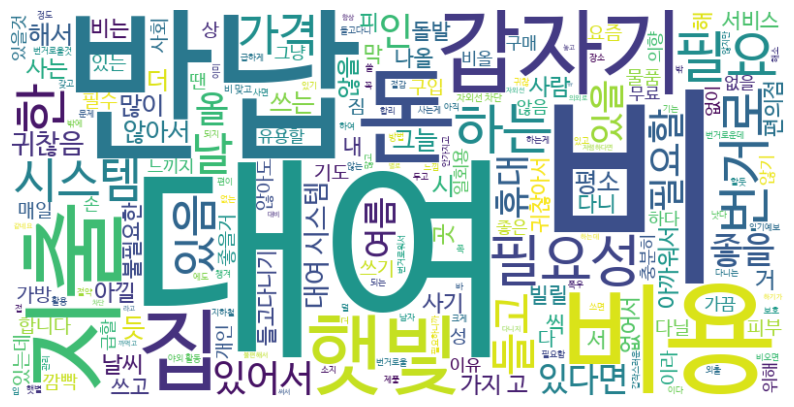

In [ ]:
# Import required libraries
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all tokenized words into a single list
all_words = []
for tokens in df_all['Tokenized_Text']:
    all_words.extend(tokens)

# Find the top 10 most common words
counter = Counter(all_words)
top_ten = counter.most_common(10)
print("Top 10 words: ", top_ten)


text = " ".join(all_words)
# Generate word cloud
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      background_color='white',
                      max_words=200,
                      width=800,
                      height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 이유 분석 -linear, Tree (선형이 가장 좋음)

선형 모델이 트리보단 더 나은 것 같다.

In [ ]:
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.7 MB/s eta 0:00:00



==== Linear 설문대상 전체 Model Evaluation ====
Loss: 0.44253018157681717
Accuracy: 0.8033707865168539

================  Linear  ================


==== 설문대상 전체 활용 이유 top 20 ====

Word: 비, Importance: 1.2703253607729643
Word: 지출, Importance: 1.0250129449069147
Word: 갑자기, Importance: 0.8344829750952397
Word: 비용, Importance: 0.831316446607783
Word: 햇빛, Importance: 0.650997647836908
Word: 좋을, Importance: 0.6393536368545847
Word: 아까워서, Importance: 0.6203702603598232
Word: 급할, Importance: 0.5847830536317276
Word: 사기, Importance: 0.5644827802262725
Word: 있다면, Importance: 0.5577891916762656
Word: 유용할, Importance: 0.5490085022467838
Word: 올, Importance: 0.5424493332673004
Word: 아낄, Importance: 0.532398732799042
Word: 차단, Importance: 0.5294941041384569
Word: 필요할, Importance: 0.49828937262800105
Word: 날씨, Importance: 0.49541272404765213
Word: 있을것, Importance: 0.4855313443633425
Word: 사는, Importance: 0.4643929644076358
Word: 절감, Importance: 0.4641259240399575
Word: 필요하니까, Importance: 0.45638338207270

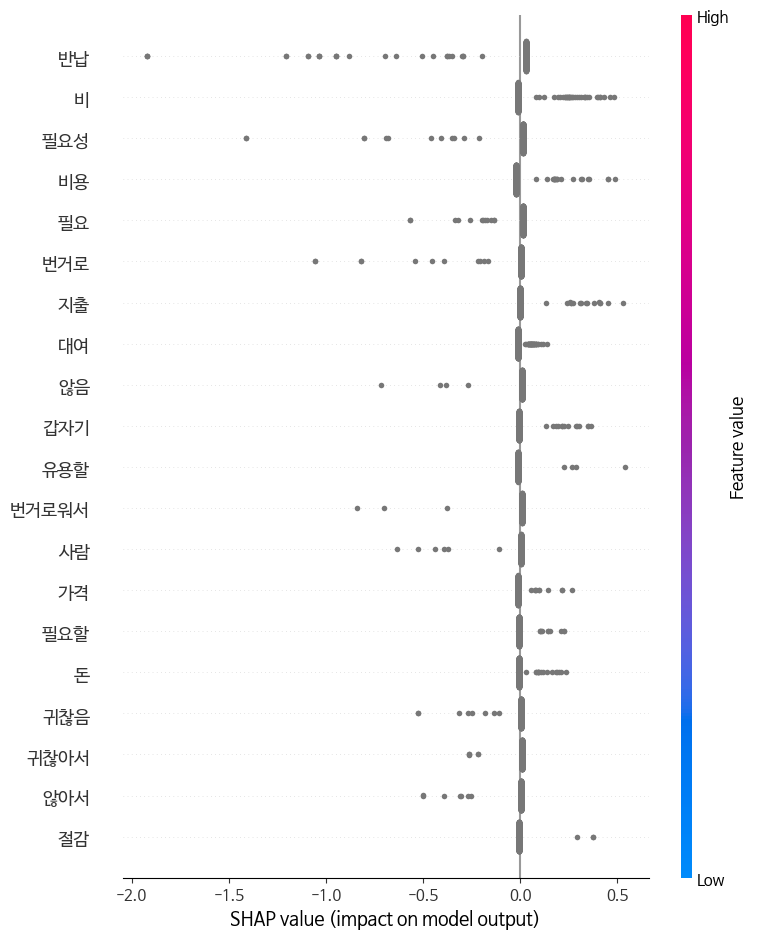


==== Linear 공유 양산 - 평소 사용자 Model Evaluation ====
Loss: 0.4915035395452651
Accuracy: 1.0

================  Linear  ================


==== 공유 양산 - 평소 사용자 활용 이유 top 20 ====

Word: 자외선, Importance: 0.44067335406886365
Word: 가방, Importance: 0.4132529852998988
Word: 차단, Importance: 0.40709999159525095
Word: 날, Importance: 0.3755136885547813
Word: 나올, Importance: 0.3718358380951868
Word: 간편할것, Importance: 0.34127110136447714
Word: 더워서, Importance: 0.34127110136447714
Word: 실용, Importance: 0.34127110136447714
Word: 좋을, Importance: 0.3177238875346197
Word: 저렴하다면, Importance: 0.2641656941938656
Word: 무거울, Importance: 0.24900763972293666
Word: 기는, Importance: 0.247712588696152
Word: 들고다니, Importance: 0.247712588696152
Word: 필수, Importance: 0.24046196956068033
Word: 깜빡, Importance: 0.22096092990582245
Word: 짐, Importance: 0.21962874648104405
Word: 들고, Importance: 0.21753990890673516
Word: 한, Importance: 0.2158387959811889
Word: 안가지고, Importance: 0.21474677046246995
Word: 날씨, Importance: 0.21258

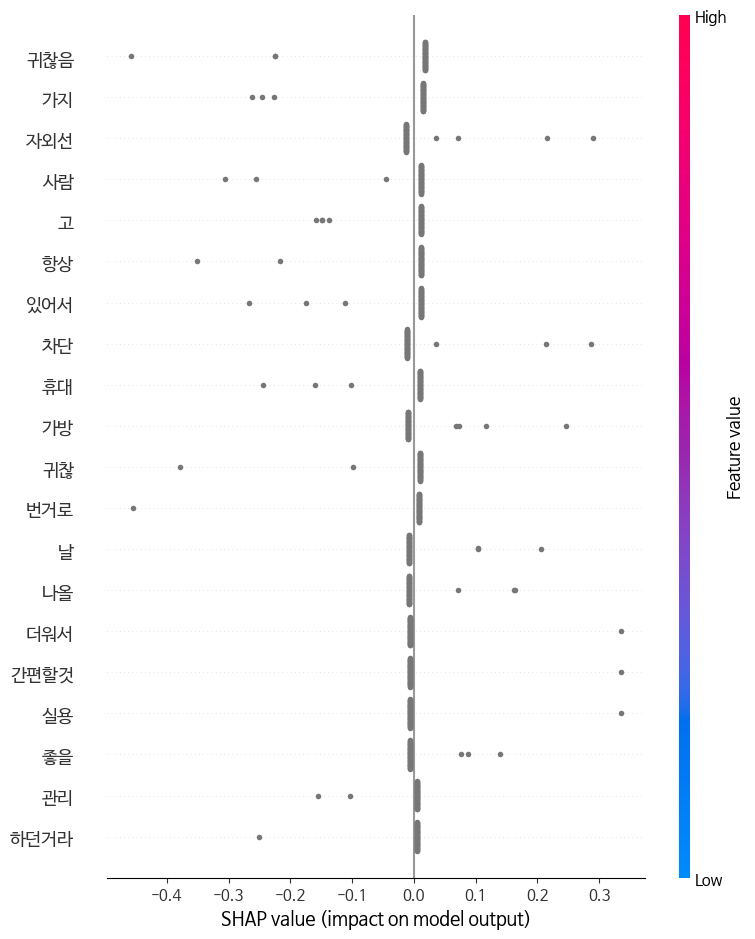


==== Linear 공유 양산 - 미사용자 Model Evaluation ====
Loss: 0.5040224763412621
Accuracy: 0.9596774193548387

================  Linear  ================


==== 공유 양산 - 미사용자 활용 이유 top 20 ====

Word: 햇빛, Importance: 0.8963121075214179
Word: 휴대, Importance: 0.6794103528748333
Word: 궁금해서, Importance: 0.5936204476622056
Word: 위해, Importance: 0.5699168481572405
Word: 피부, Importance: 0.5587114700753477
Word: 해소, Importance: 0.47180375542691266
Word: 있을, Importance: 0.442829242113228
Word: 강해서, Importance: 0.43840470306435997
Word: Useful, Importance: 0.4383712778203832
Word: x, Importance: 0.4383712778203832
Word: 썬크림, Importance: 0.4383712778203832
Word: 편할듯, Importance: 0.4383712778203832
Word: 불, Importance: 0.4278173499929644
Word: 여름, Importance: 0.4231155486692318
Word: 요즘, Importance: 0.390946698647041
Word: 다니는, Importance: 0.3875204144629059
Word: 유용할, Importance: 0.37458549980086203
Word: 번거로운데, Importance: 0.3743701081126155
Word: 있다면, Importance: 0.37009634787704676
Word: 차단, Importance:

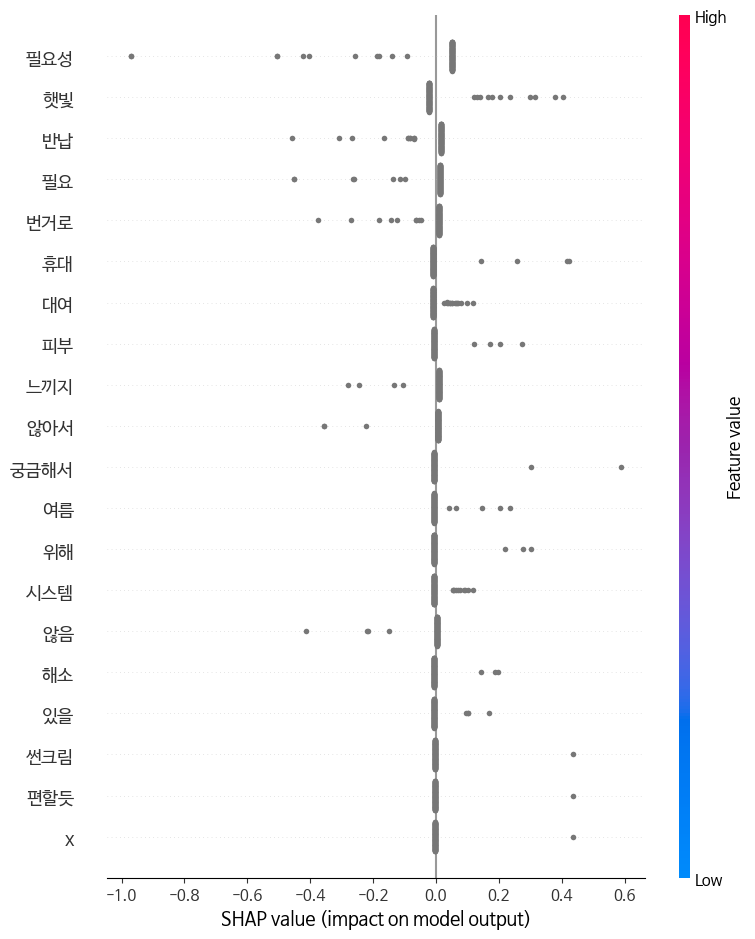


==== Linear 공유 우산 Model Evaluation ====
Loss: 0.33058021329920945
Accuracy: 0.8595505617977528

================  Linear  ================


==== 공유 우산 활용 이유 top 20 ====

Word: 비, Importance: 0.7698918582300424
Word: 지출, Importance: 0.6189074200203463
Word: 비용, Importance: 0.5545993488575915
Word: 갑자기, Importance: 0.47623328562791106
Word: 아까워서, Importance: 0.3797274787634046
Word: 돈, Importance: 0.37691217881734845
Word: 대여, Importance: 0.37537341376181965
Word: 급할, Importance: 0.3528958838685541
Word: 올, Importance: 0.3512279624258264
Word: 아낄, Importance: 0.30168938995897565
Word: 있음, Importance: 0.2956256350949311
Word: 필요, Importance: 0.2907935744440329
Word: 사는, Importance: 0.2809429898620975
Word: 필요하니까, Importance: 0.2784460133813509
Word: 피, Importance: 0.2772968887880647
Word: 절감, Importance: 0.276469233796659
Word: 필요할, Importance: 0.26947010120927195
Word: 사기, Importance: 0.2677427036224192
Word: 맞고, Importance: 0.25260264967418855
Word: 좋을, Importance: 0.25008430396364173

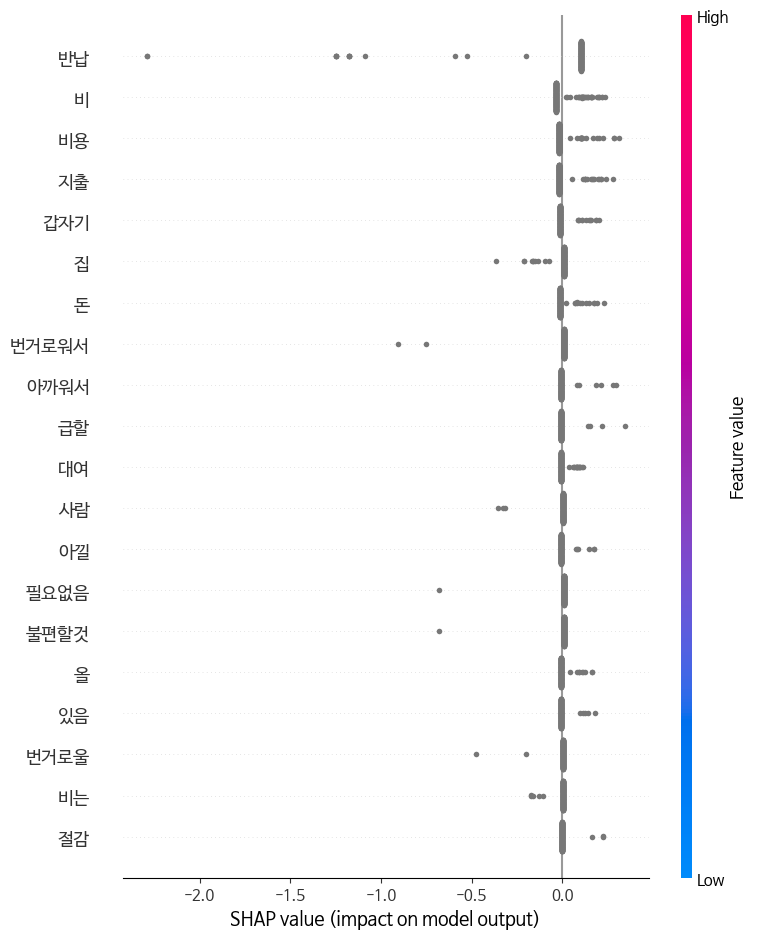

 ============================================= Tree  =============================================

==== CatBoost 전체 대상 Model Evaluation ====
Accuracy: 0.8117977528089888

================  CatBoost  ================


==== 전체 대상 Model Evaluation ====
Loss: 0.44515475251975667
Accuracy: 0.8117977528089888

==== 전체 대상 ====



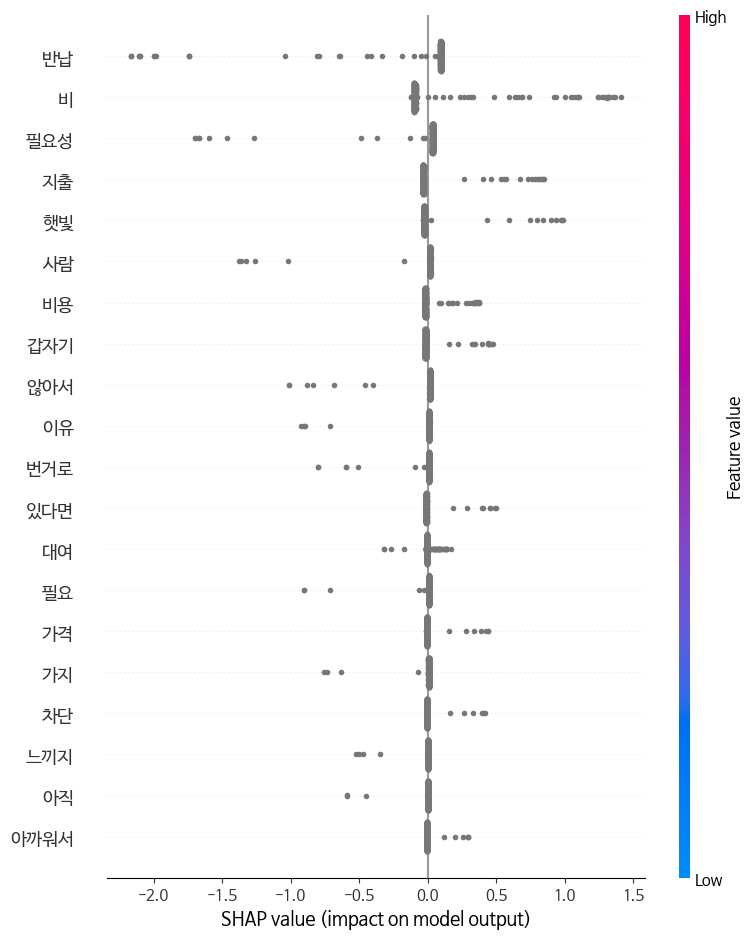


==== CatBoost 공유 양산 - 평소 사용자 Model Evaluation ====
Accuracy: 0.8888888888888888

================  CatBoost  ================


==== 공유 양산 - 평소 사용자 Model Evaluation ====
Loss: 0.47240065453150354
Accuracy: 0.8888888888888888

==== 공유 양산 - 평소 사용자 ====



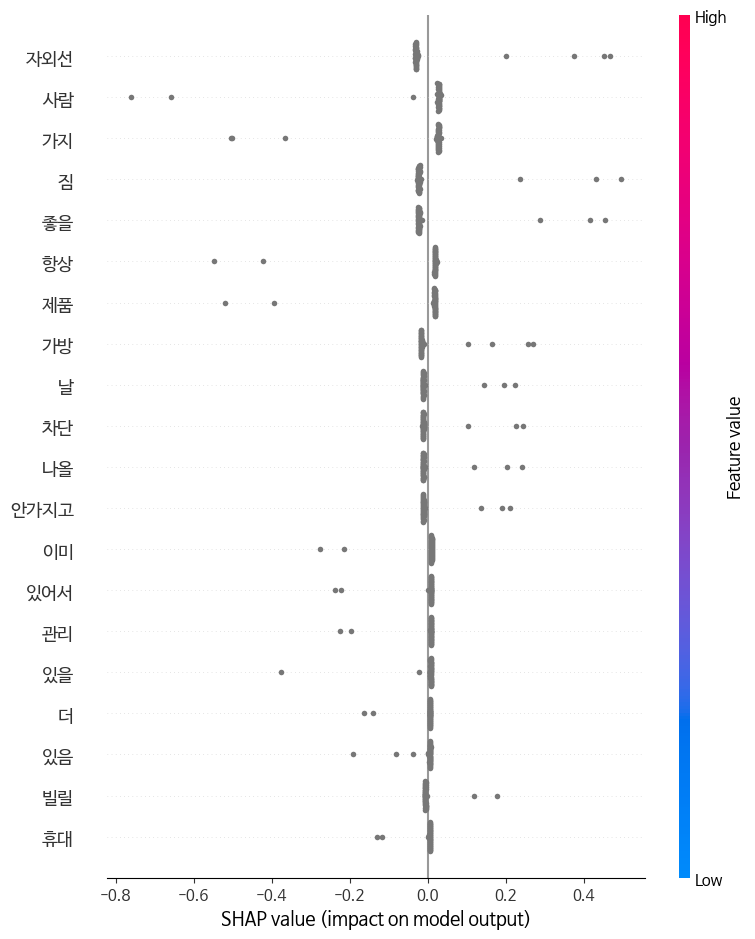


==== CatBoost 공유 양산 - 미사용자 Model Evaluation ====
Accuracy: 0.8306451612903226

================  CatBoost  ================


==== 공유 양산 - 미사용자 Model Evaluation ====
Loss: 0.4786626442814223
Accuracy: 0.8306451612903226

==== 공유 양산 - 미사용자 ====



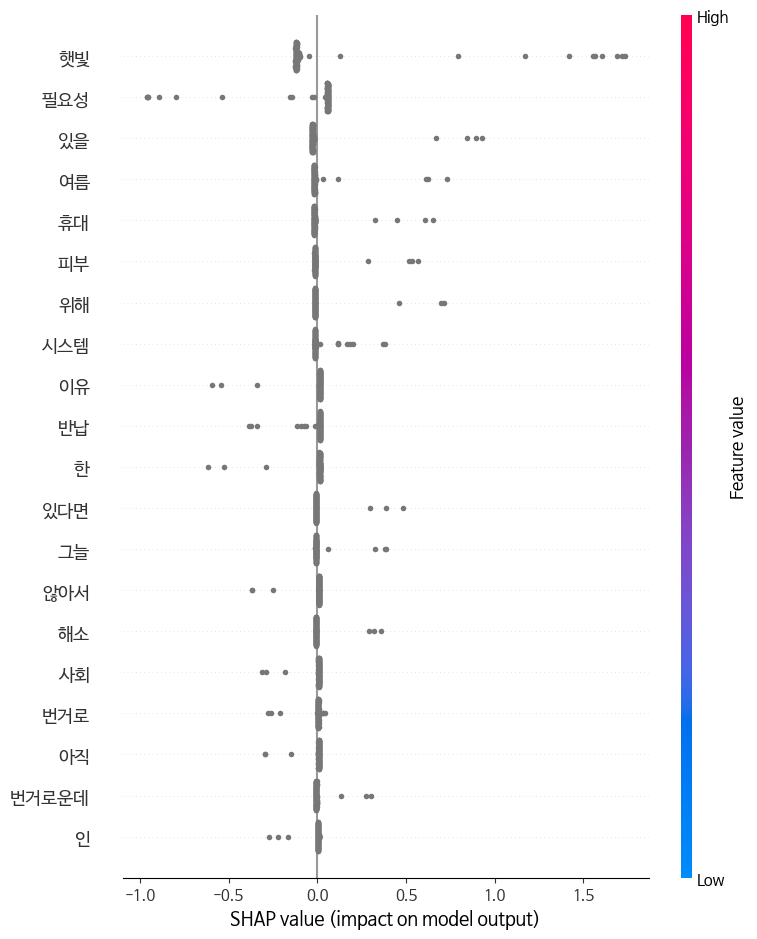


==== CatBoost 공유 우산 Model Evaluation ====
Accuracy: 0.8820224719101124

================  CatBoost  ================


==== 공유 우산 Model Evaluation ====
Loss: 0.2630477330306937
Accuracy: 0.8820224719101124

==== 공유 우산 ====



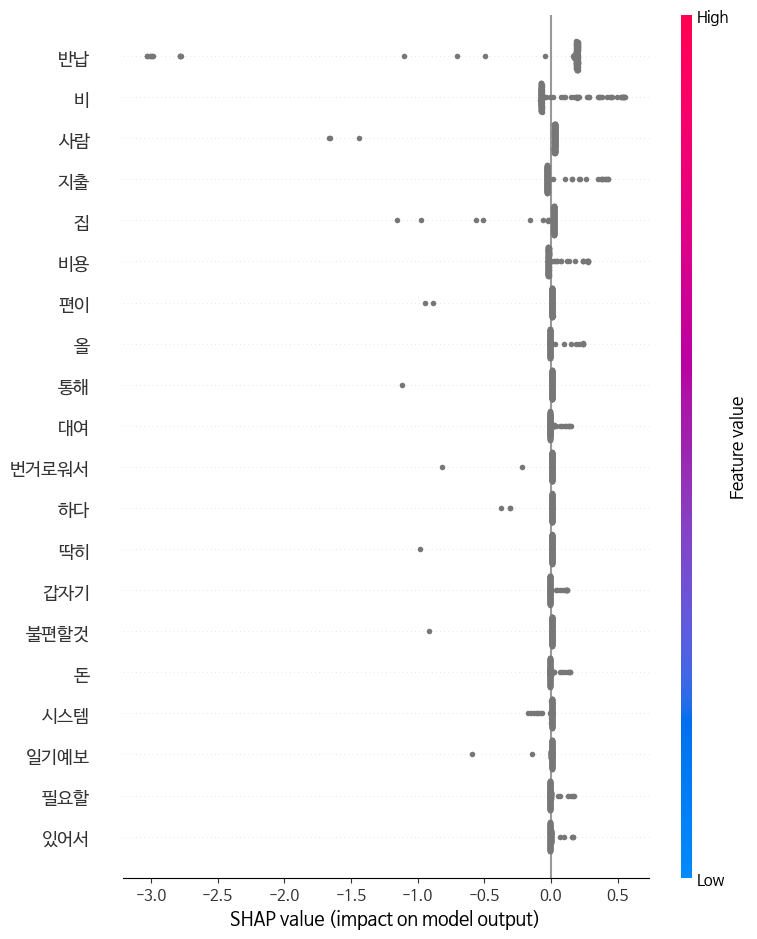

[08:05:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

[08:05:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



==== XGBoost 전체 대상 Model Evaluation ====
Accuracy: 0.8314606741573034

================  XGBoost  ================


==== 전체 대상 Model Evaluation ====
Loss: 0.370934465845391
Accuracy: 0.8314606741573034

==== 전체 대상 ====



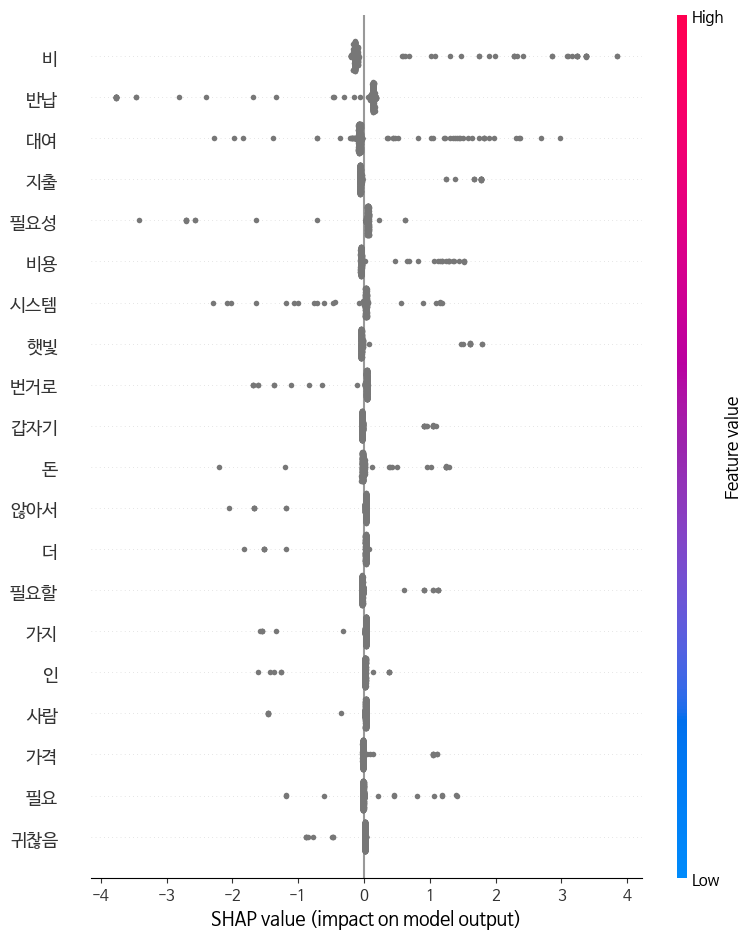

[08:05:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.




==== XGBoost 공유 양산 - 평소 사용자 Model Evaluation ====
Accuracy: 0.5925925925925926

================  XGBoost  ================


==== 공유 양산 - 평소 사용자 Model Evaluation ====
Loss: 0.6405847901574074
Accuracy: 0.5925925925925926

==== 공유 양산 - 평소 사용자 ====



[08:05:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


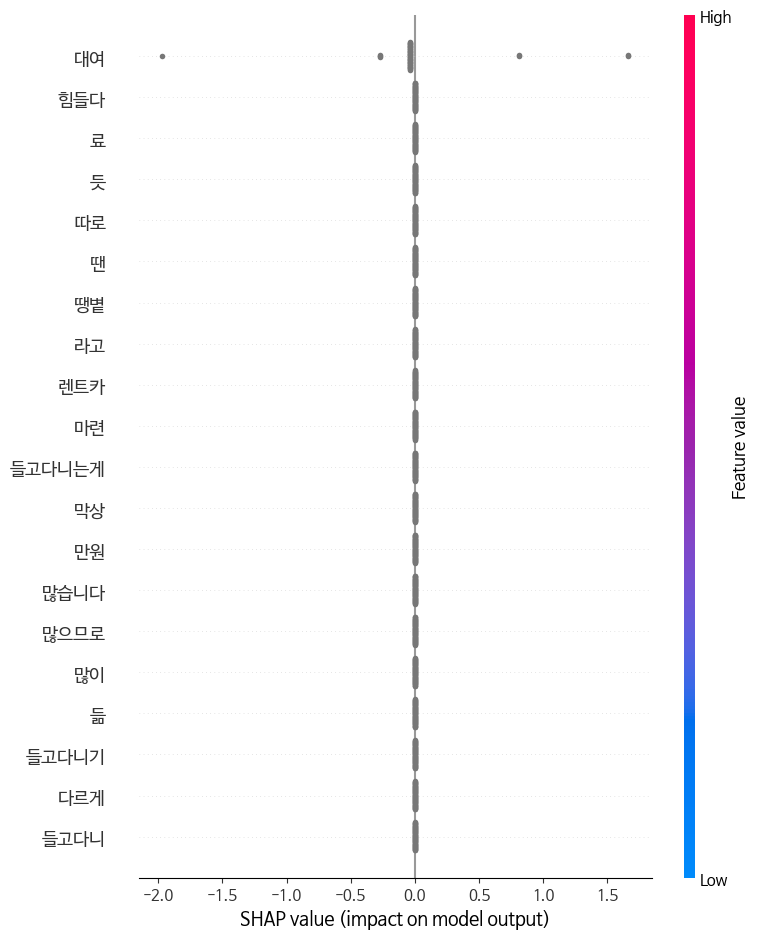

[08:05:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

[08:05:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



==== XGBoost 공유 양산 - 미사용자 Model Evaluation ====
Accuracy: 0.7016129032258065

================  XGBoost  ================


==== 공유 양산 - 미사용자 Model Evaluation ====
Loss: 0.5200682788196438
Accuracy: 0.7016129032258065

==== 공유 양산 - 미사용자 ====



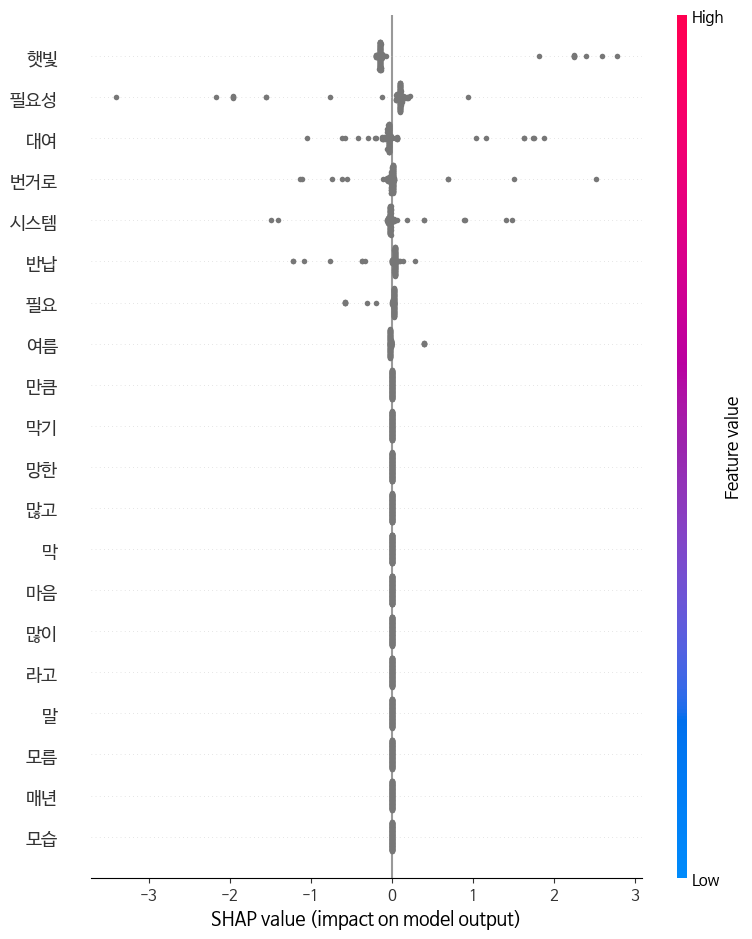

[08:05:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

[08:05:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



==== XGBoost 공유 우산 Model Evaluation ====
Accuracy: 0.8932584269662921

================  XGBoost  ================


==== 공유 우산 Model Evaluation ====
Loss: 0.305383215872907
Accuracy: 0.8932584269662921

==== 공유 우산 ====



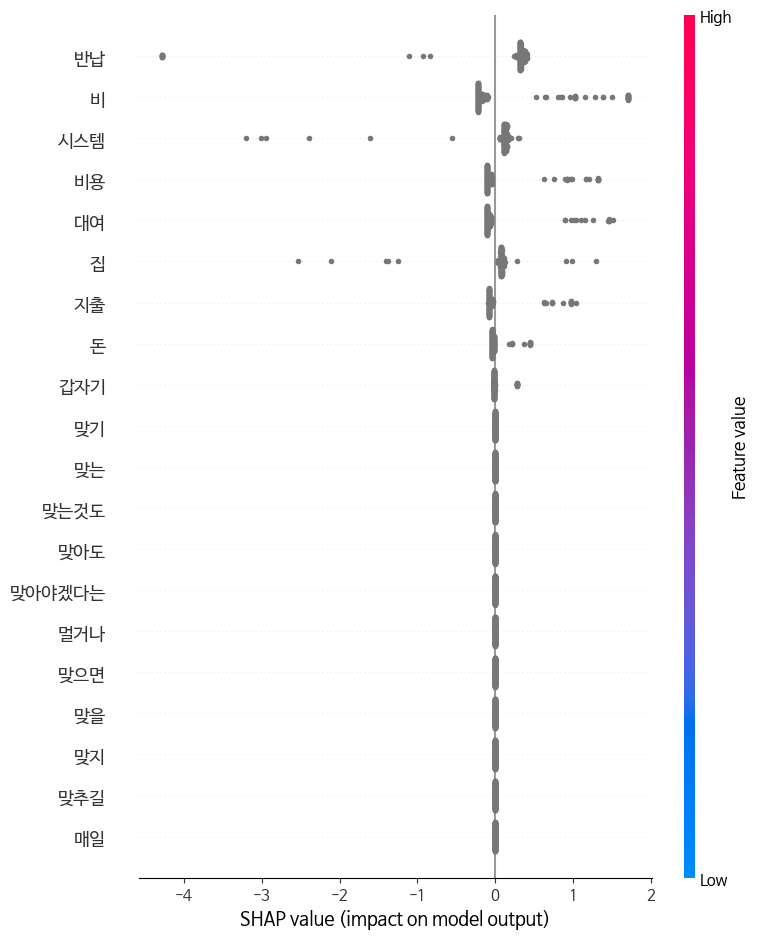

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error

def evaluate_model(model, x, y, vectorizer, title, modelname):
    # Fit the model
    model.fit(x, y)

    # For scikit-learn models
    y_pred = model.predict(x)
    y_prob = model.predict_proba(x)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y, y_pred)
    loss = log_loss(y, y_prob) if y_prob is not None else None
    print(f"\n==== {modelname} {title} Model Evaluation ====")
    if loss is not None:
        print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")


    # Get feature importance
    feature_names = vectorizer.get_feature_names_out()
    if hasattr(model, 'coef_'):
        importance = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        print("The model does not support feature importance directly")
        return

    # Sort features by their importance
    word_importance = list(zip(feature_names, importance))
    sorted_word_importance = sorted(word_importance, key=lambda x: x[1], reverse=True)

    top_20_words = sorted_word_importance[:20]
    bottom_20_words = sorted_word_importance[-20:]


    print(f"\n================  {modelname}  ================\n")
    # Print top 20 and bottom 20 important features
    print(f"\n==== {title} 활용 이유 top 20 ====\n")
    for word, imp in top_20_words:
        print(f"Word: {word}, Importance: {imp}")

    print(f"\n==== {title} 활용 않을 이유 top 20 ====\n")
    for word, imp in bottom_20_words:
        print(f"Word: {word}, Importance: {imp}")

    print(f'\n==== {title} Shap ====\n')
    explainer = shap.LinearExplainer(model, x)
    # explainer = shap.Explainer(model)
    shap_values = explainer(x)
    shap.summary_plot(shap_values, x, feature_names=feature_names)


def evaluate_tree_model(model, x, y, vectorizer,title, modelname ):
    model.fit(x, y)

    # Predict the labels
    y_pred = model.predict(x)

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)

    print(f"\n==== {modelname} {title} Model Evaluation ====")
    print(f"Accuracy: {accuracy}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(x)
    # Summarize the SHAP values in a plot
    print(f"\n================  {modelname}  ================\n")
    # For scikit-learn models
    if hasattr(model, 'predict'):
        y_pred = model.predict(x)
        # For classification models
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(x)[:, 1]
            try:
                accuracy = accuracy_score(y, y_pred.round())
                loss = log_loss(y, y_prob)
                print(f"\n==== {title} Model Evaluation ====")
                print(f"Loss: {loss}")
                print(f"Accuracy: {accuracy}")
            except ValueError:
                # Handles regression models
                mse = mean_squared_error(y, y_pred)
                print(f"\n==== {title} Model Evaluation ====")
                print(f"Mean Squared Error: {mse}")
        # For regression models
        else:
            mse = mean_squared_error(y, y_pred)
            print(f"\n==== {title} Model Evaluation ====")
            print(f"Mean Squared Error: {mse}")

    # For Keras models
    else:
        loss, metric = model.evaluate(x, y, verbose=0)
        print(f"\n==== {title} Model Evaluation ====")
        print(f"Loss: {loss}")
        print(f"Metric: {metric}")




    print(f"\n==== {title} ====\n")
    shap.summary_plot(shap_values, x, feature_names=vectorizer.get_feature_names_out())



import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import shap

''' ================= Linear  ================='''
evaluate_model(LogisticRegression(), x_all, y_all, vectorizer_all, '설문대상 전체','Linear')
evaluate_model(LogisticRegression(), x_par, y_par, vectorizer_par, '공유 양산 - 평소 사용자','Linear')
evaluate_model(LogisticRegression(), x_par_no, y_par_no, vectorizer_par_no, '공유 양산 - 미사용자','Linear')
evaluate_model(LogisticRegression(), x_um, y_um, vectorizer_um, '공유 우산', 'Linear')


'''
cat_reg = CatBoostRegressor(iterations=1000,
                                learning_rate=0.01,
                                depth=5,
                                l2_leaf_reg=6,
                                bootstrap_type='Bayesian',
                                loss_function='RMSE',
                                random_seed=0,
                                verbose=False)
XGBRegressor(seed = seed, n_estimators = xgb_params.iloc[building_number-1, 7], eta = 0.01,
                           min_child_weight = xgb_params.iloc[building_number-1, 2], max_depth = xgb_params.iloc[building_number-1, 3],
                           colsample_bytree=xgb_params.iloc[building_number-1, 4], subsample=xgb_params.iloc[building_number-1, 5])
'''
''' ================= Tree  ================='''
print(''' ============================================= Tree  =============================================''')
evaluate_tree_model(CatBoostClassifier(verbose=False), x_all, y_all, vectorizer_all, '전체 대상','CatBoost')
evaluate_tree_model(CatBoostClassifier(verbose=False), x_par, y_par, vectorizer_par, '공유 양산 - 평소 사용자','CatBoost')
evaluate_tree_model(CatBoostClassifier(verbose=False), x_par_no, y_par_no, vectorizer_par_no, '공유 양산 - 미사용자','CatBoost')
evaluate_tree_model(CatBoostClassifier(verbose=False), x_um, y_um, vectorizer_um, '공유 우산', 'CatBoost')


evaluate_tree_model(XGBClassifier(verbose=False), x_all, y_all, vectorizer_all, '전체 대상','XGBoost')
evaluate_tree_model(XGBClassifier(verbose=False), x_par, y_par, vectorizer_par, '공유 양산 - 평소 사용자','XGBoost')
evaluate_tree_model(XGBClassifier(verbose=False), x_par_no, y_par_no, vectorizer_par_no, '공유 양산 - 미사용자','XGBoost')
evaluate_tree_model(XGBClassifier(verbose=False), x_um, y_um, vectorizer_um, '공유 우산', 'XGBoost')



## Bert - 사용 X 너무  overkilling

KoBert 사전학습 모델을 fine tunning해볼까 했지만....
너무 overkilling이다. 선형 모델이 이미 충분히 좋은 성능을 보이는 문제이므로 하지 않는다.

In [ ]:
# 맨 위에서 안돌렸다면 이거 돌리고 런타임 다시시작 후 밑에서 부터
!pip install transformers
!pip install "transformers[torch]" -U

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("WhitePeak/bert-base-cased-Korean-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("WhitePeak/bert-base-cased-Korean-sentiment")

Fine Tunning

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
def compute_metrics(p):
    pred_flat = np.argmax(p.predictions, axis=1).flatten()
    labels_flat = p.label_ids.flatten()
    acc = accuracy_score(labels_flat, pred_flat)
    return {"accuracy": acc}

x = df_all['text'].tolist()
y = df_all['label'].tolist()

# Tokenize the dataset
encoding = tokenizer(x, padding=True, truncation=True)
input_ids = torch.tensor(encoding['input_ids'])
attention_mask = torch.tensor(encoding['attention_mask'])
labels = torch.tensor(y, dtype=torch.long)  # Cast to long integer type

from torch.utils.data import random_split

# Create a DataLoader
dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)

# Calculate the lengths of train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset = CustomDataset(input_ids[:train_size], attention_mask[:train_size], labels[:train_size])
val_dataset = CustomDataset(input_ids[train_size:], attention_mask[train_size:], labels[train_size:])

# Your existing code for setting up trainer should work now
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    # 추가
    logging_dir='./logs',
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Add this line
)

# Fine-tune the model
trainer.train()

Step,Training Loss


TrainOutput(global_step=93, training_loss=0.7191405757780998, metrics={'train_runtime': 1259.1909, 'train_samples_per_second': 0.586, 'train_steps_per_second': 0.074, 'total_flos': 48164739794280.0, 'train_loss': 0.7191405757780998, 'epoch': 3.0})

simple  Gradient-based Interpretation

In [ ]:
# Choose an example from your validation set
example_input_ids = input_ids
example_attention_mask = attention_mask

# Forward pass
model = trainer.model
model.eval()  # Set the model to evaluation mode
outputs = model(example_input_ids, attention_mask=example_attention_mask)

# Get the output for the specific class (0 or 1 in your case)
output_for_positive = outputs.logits[:, 1]  # Change this to 0 for "negative" if needed

# Zero gradients (useful when doing multiple passes)
model.zero_grad()

# Enable gradient calculation for the parameters
for param in model.parameters():
    param.requires_grad = True

# Perform backward pass to calculate gradients
output_for_positive.backward(torch.ones_like(output_for_positive))

# Extract the gradients for the embeddings from the model
embedding_gradients = model.bert.embeddings.word_embeddings.weight.grad[example_input_ids].detach().numpy()

# Let's get the tokens corresponding to the input ids for interpretation
tokens = tokenizer.convert_ids_to_tokens(example_input_ids[0])  # Assuming batch size is 1

# Zip tokens with their corresponding gradients (taking sum over embedding dimensions)
token_importance = list(zip(tokens, embedding_gradients.sum(axis=2)[0]))

# Sort tokens by importance
sorted_tokens = sorted(token_importance, key=lambda x: x[1], reverse=True)

# Print sorted tokens with importance
for token, importance in sorted_tokens:
  if token != "[PAD]":
    print(f"Token: {token}, Importance: {importance}")


NameError: ignored

## DNN shap - 사용 x

In [ ]:
!pip install shap

양산

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1054)]            0         
                                                                 
 dense (Dense)               (None, 8)                 8440      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
9/9 [==============================] - 3s 144ms/step - loss: 0.6972 - accuracy: 0.4655 - val_loss: 0.6972 - val_accuracy: 0.4203
Epoch 2/300
9/9 [=

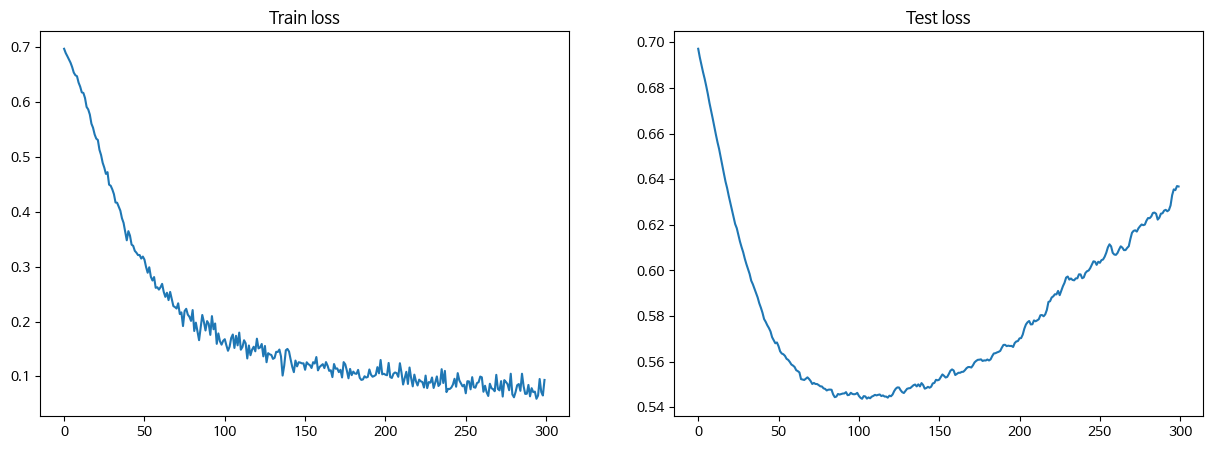

In [ ]:
from keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras.backend as K

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, random_state=66, test_size=0.2)
x_train_dense = x_train.toarray()
x_val_dense = x_val.toarray()

K.clear_session()

input_layer = Input(shape=(x_all.shape[1],), sparse=True)
dense1 = Dense(8, activation='relu')(input_layer)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(8, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

dense3 = Dense(3, activation='relu')(dropout2)
dropout3 = Dropout(0.5)(dense3)

dense4 = Dense(3, activation='relu')(dropout3)
dropout4 = Dropout(0.5)(dense4)


output_layer = Dense(1, activation='sigmoid')(dropout1) # dropout2
model = Model(inputs=input_layer, outputs=output_layer)



'''
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

lr_schedule = ExponentialDecay(initial_learning_rate=0.003, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

history = model.fit(x_train_dense, y_train, epochs=5000, batch_size=128,
                    validation_data=(x_val_dense, y_val), callbacks=[early_stopping])
'''
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()
# Then, you can proceed to fit the model as usual
history =model.fit(x_train_dense, y_train, epochs=300, batch_size=32, validation_data=(x_val_dense, y_val) )

def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

plot_history(history)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


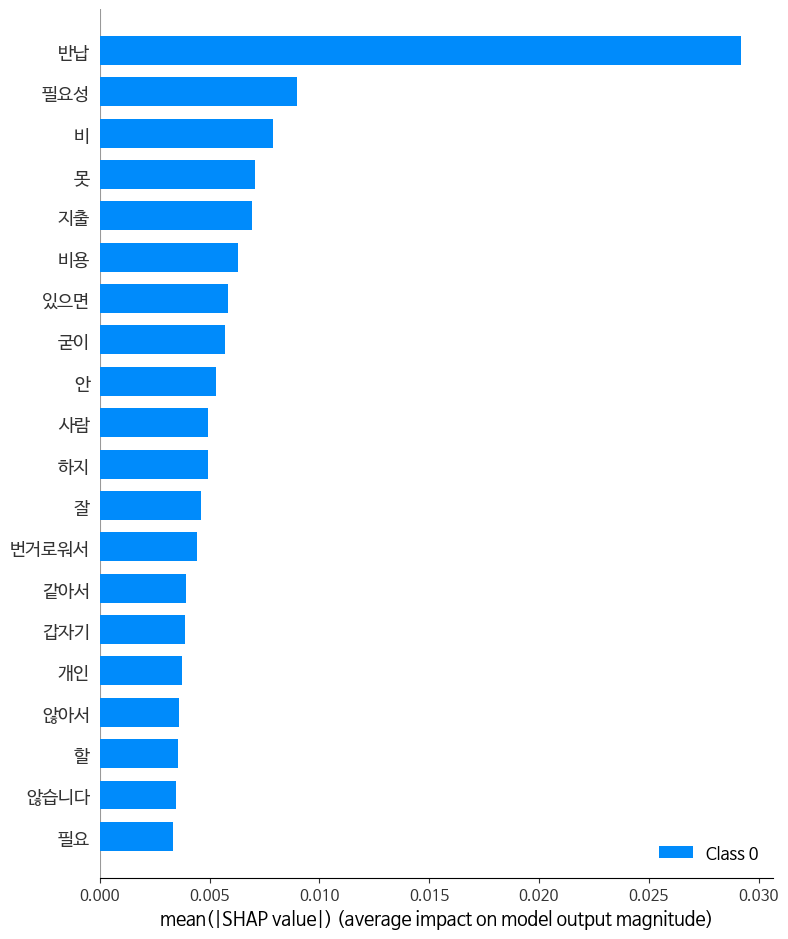

In [ ]:
import shap
e = shap.DeepExplainer(model, x_train_dense)
shap_values = e.shap_values(x_train_dense)
shap.summary_plot(shap_values, x_train_dense,feature_names=vectorizer_all.get_feature_names_out())